In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import missingno as msno
from scipy import interpolate

       Unnamed: 0  WELLNUM         DEPTH        DTC  DTS       DEN         GR  \
0               0        0  14121.660105   89.64610  NaN  2.577700   88.85730   
1               1        0  14122.160105   96.01520  NaN  2.474800  120.89490   
2               2        0  14122.660105  104.04570  NaN  2.333800  153.51950   
3               3        0  14123.160105  113.50100  NaN  2.235800  182.85310   
4               4        0  14123.660105  117.78170  NaN  2.227800  256.19600   
...           ...      ...           ...        ...  ...       ...        ...   
42304       42304        8  12142.500000   64.57612  NaN  2.613020   32.91600   
42305       42305        8  12143.000000   66.20669  NaN  2.614332   28.76523   
42306       42306        8  12143.500000   67.43187  NaN  2.620479   25.70403   
42307       42307        8  12144.000000   66.56465  NaN  2.623435   22.94222   
42308       42308        8  12144.500000   66.92158  NaN  2.617516   22.30438   

            NEU      PEF   

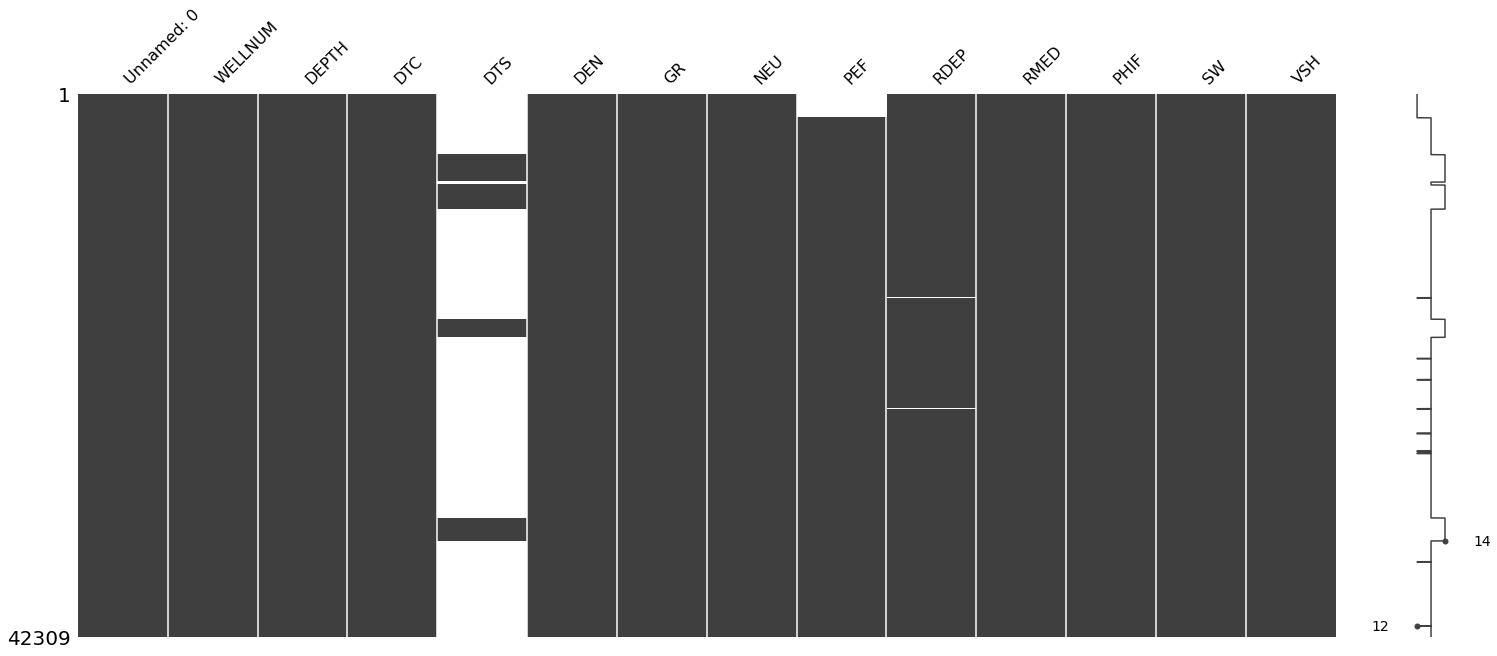

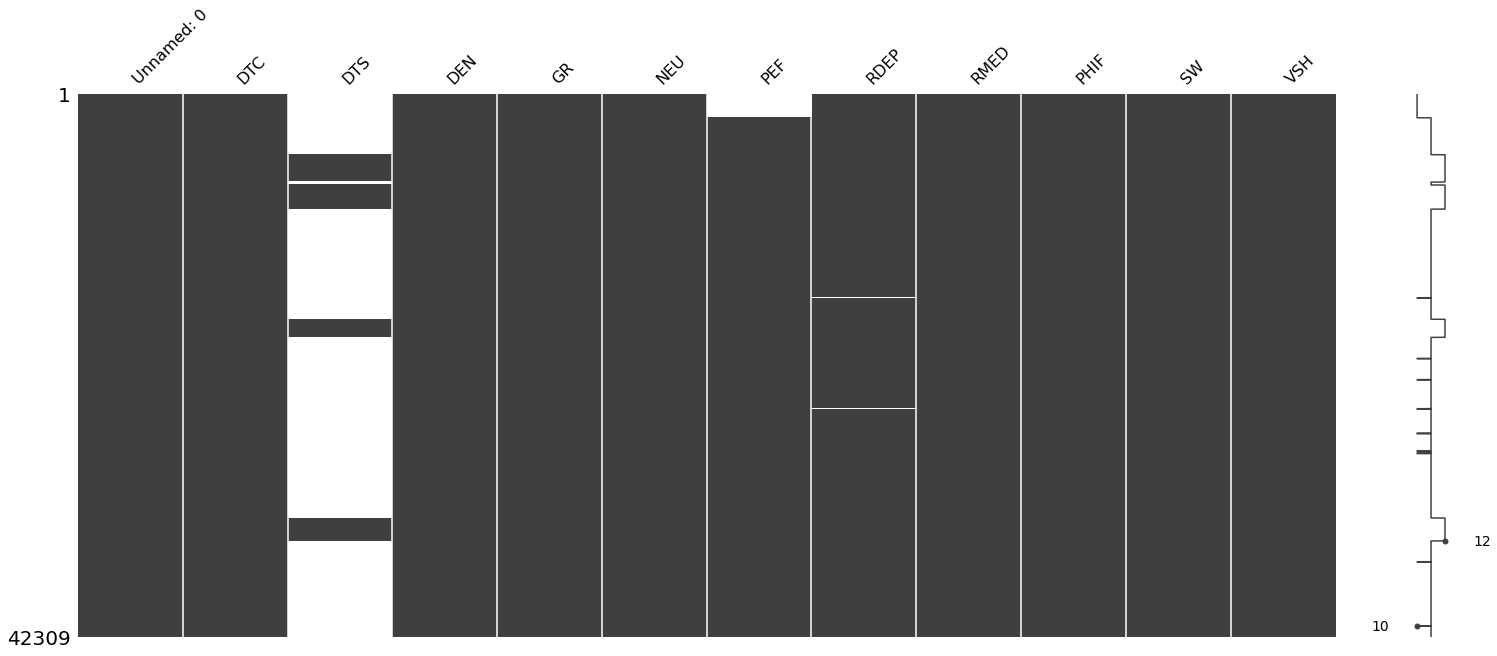

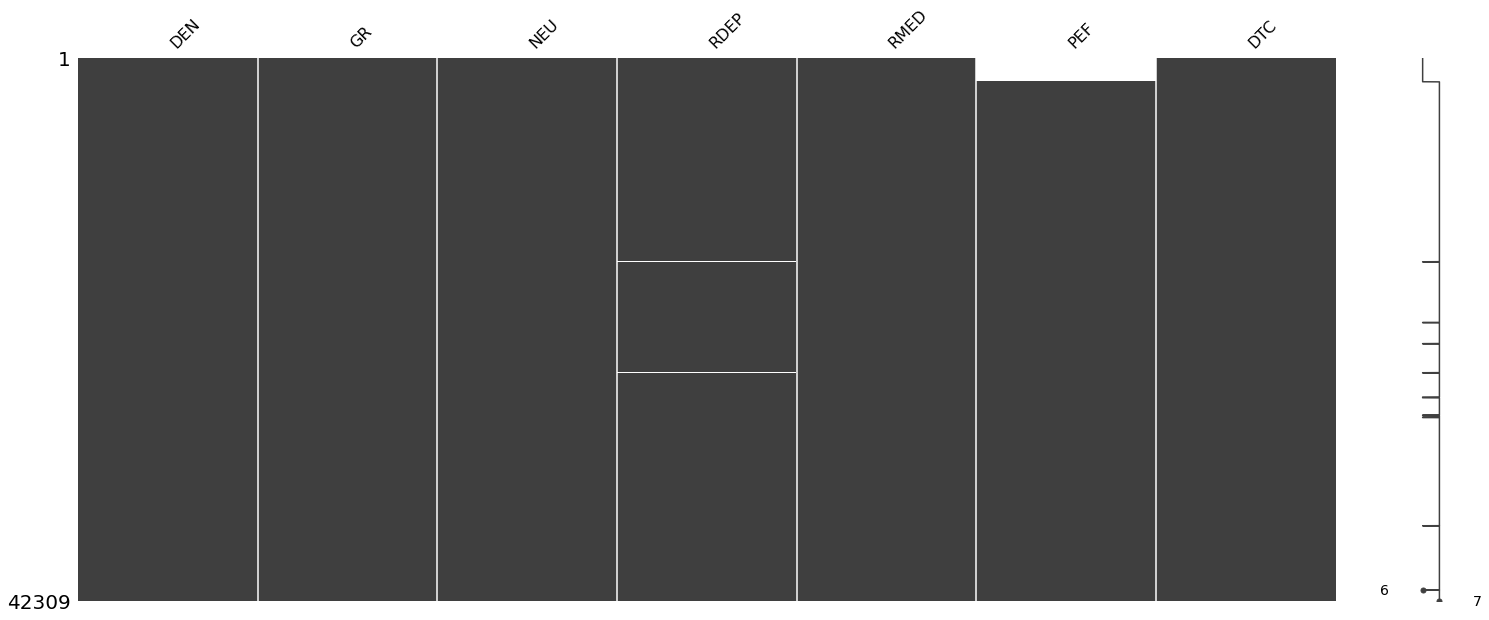

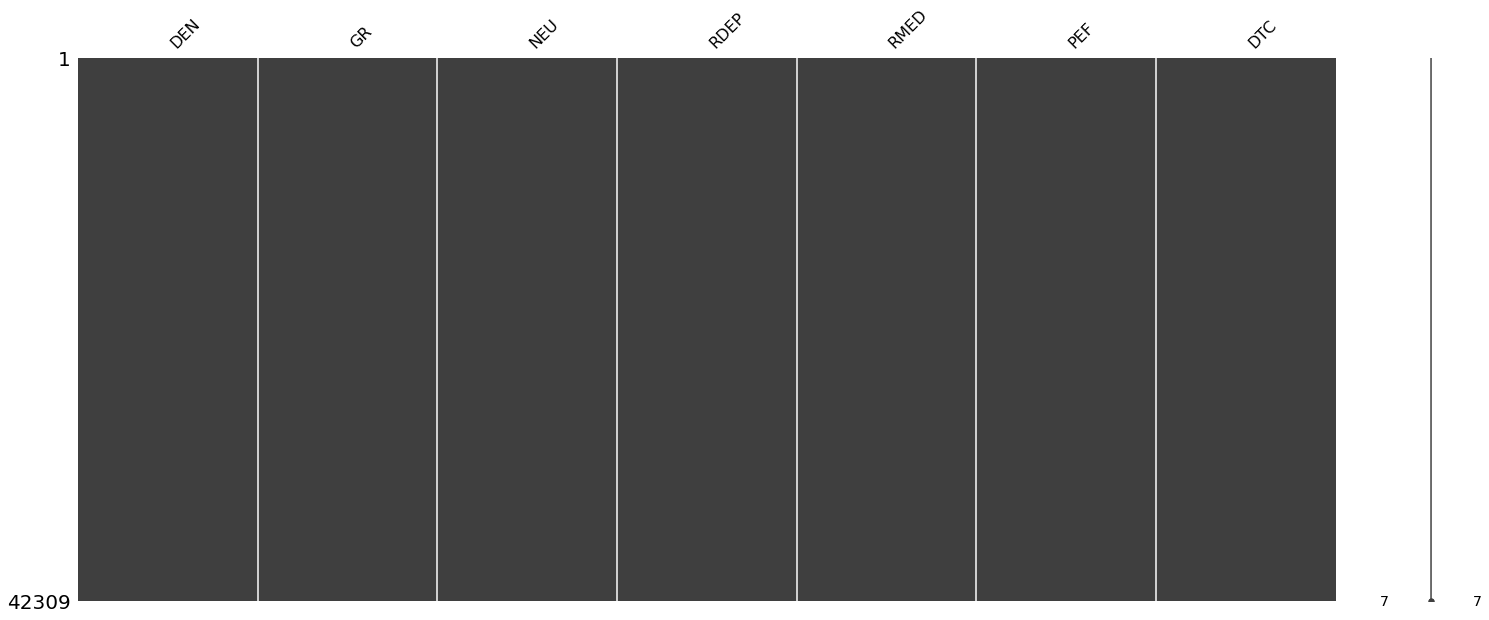

In [2]:
#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset_filling/dtc_predictions/train_dataset_dtc_2.csv"
train_data = pd.read_csv(train_path)
print(train_data)

discarded =  ["WELLNUM", "DEPTH"]
targets = ['PHIF', 'VSH', 'SW']
features = ["DEN","GR","NEU", "RDEP","RMED", "PEF", "DTC"]
msno.matrix(train_data)
train_data = train_data.drop(columns=discarded)

#train_data = train_data.dropna()

#train_data = train_data.sample(n=1000,replace=False)
print(len(train_data))

msno.matrix(train_data)
#separate in x (inputs) and y(targets or outputs)
x_train = train_data.loc[:, features]
y_train = train_data.loc[:, targets]
msno.matrix(x_train)
x_train = x_train.interpolate()
pef_mean = np.mean(x_train["PEF"])
print(pef_mean)
x_train['PEF'] = x_train['PEF'].fillna(pef_mean)
#pef_mean = np.mean(x_train["DTS"])
#print(pef_mean)
#x_train['DTS'] = x_train['DTS'].fillna(pef_mean)
msno.matrix(x_train)

#adjust values of targets:
#SW 0-1
#0<PHIF
# 0<VSH 
print(y_train.describe())
#y_train.loc[y_train["SW"] < 0, "SW"] = 0
#y_train.loc[y_train["SW"] > 1, "SW"] = 1
#y_train.loc[y_train["PHIF"] < 0, "PHIF"] = 0
#y_train.loc[y_train["PHIF"] > 1, "PHIF"] = 1
#y_train.loc[y_train["VSH"] < 0, "VSH"] = 0
print(y_train.describe())


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)

#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))


In [3]:
#training history plotting function
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error ')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

 
  plt.show()

In [4]:
#model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.1),
   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
   
    
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[ tf.keras.metrics.RootMeanSquaredError()])
  return model

#create a model instance
checkpoint_path = r"/Users/astromeria/Documents/SPWLA_competition/weights/26Jan.h5"
checkpoint = keras.callbacks.ModelCheckpoint( checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model()

history = model.fit(
  x_train, y_train,
  epochs=150, validation_split = 0.1, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
#plot_history(history)

2022-02-01 14:59:33.038689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 14:59:33.084299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/150
1012/1012 - 1s - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 2/150
1012/1012 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 3/150
1012/1012 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 4/150
1012/1012 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0604 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 5/150
1012/1012 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 6/150
1012/1012 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 7/150
1012/1012 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 8/150
1012/1012 - 0s - loss: 0.0028 - root_mean_squared_error: 

Epoch 62/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 63/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 8.2646e-04 - val_root_mean_squared_error: 0.0287
Epoch 64/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 8.5141e-04 - val_root_mean_squared_error: 0.0292
Epoch 65/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 8.8653e-04 - val_root_mean_squared_error: 0.0298
Epoch 66/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 8.4583e-04 - val_root_mean_squared_error: 0.0291
Epoch 67/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 8.8820e-04 - val_root_mean_squared_error: 0.0298
Epoch 68/150
1012/1012 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 8.5858e-04 - val_root_mean_squared_error: 0.0293
Epoch 69/150
1012/1012 - 0s - loss: 0.

Epoch 122/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 7.4612e-04 - val_root_mean_squared_error: 0.0273
Epoch 123/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 9.2476e-04 - val_root_mean_squared_error: 0.0304
Epoch 124/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 9.4110e-04 - val_root_mean_squared_error: 0.0307
Epoch 125/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 8.4697e-04 - val_root_mean_squared_error: 0.0291
Epoch 126/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 7.6086e-04 - val_root_mean_squared_error: 0.0276
Epoch 127/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 8.2041e-04 - val_root_mean_squared_error: 0.0286
Epoch 128/150
1012/1012 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 8.7357e-04 - val_root_mean_squared_error: 0.0296
Epoch 129/150
1012/1012 - 0

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
145,0.001822,0.042682,0.000803,0.028338,145
146,0.001772,0.042101,0.000959,0.030960,146
147,0.001772,0.042091,0.000928,0.030457,147
148,0.001740,0.041707,0.000813,0.028509,148
149,0.001787,0.042269,0.000855,0.029238,149


199/199 - 0s - loss: 7.6405e-04 - root_mean_squared_error: 0.0276
<bound method NDFrame.head of          PHIF     VSH      SW
29839  0.1630  0.2990  0.5340
16304  0.2252  0.1103  0.1638
12166  0.2416  0.2439  0.2153
13891  0.2374  0.3244  0.4854
9821   0.0599  0.4321  0.5101
...       ...     ...     ...
5382   0.1908  0.2894  0.9348
22407  0.2360  0.1000  0.1000
13955  0.1804  0.1138  0.0793
21904  0.0850  0.3740  0.7980
19628  0.1180  0.2750  0.7950

[6347 rows x 3 columns]>


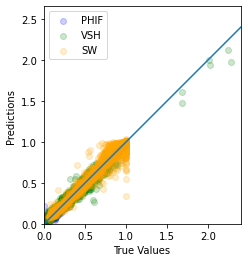

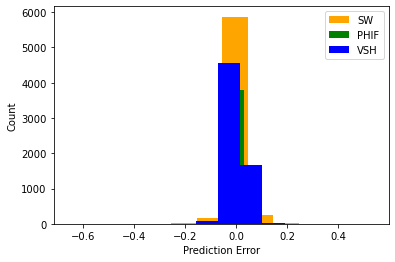

In [5]:
model.load_weights(checkpoint_path)

loss, mse = model.evaluate(x_test, y_test, verbose=2)
test_predictions = model.predict(x_test)
print(y_test.head)

col_names_y = [ "PHIF","VSH", "SW"]
plt.scatter(y_test["PHIF"], test_predictions[:,0], color = "blue", label = col_names_y[0], alpha=0.2)
plt.scatter(y_test["VSH"], test_predictions[:,1], color = "green", label = col_names_y[1], alpha=0.2)
plt.scatter(y_test["SW"], test_predictions[:,2], color = "orange", label = col_names_y[2],alpha=0.2)



           
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions - np.asarray(y_test)
plt.hist(error[:,2] , color="orange", label = col_names_y[2])
plt.hist(error[:,0], color = "green", label = col_names_y[0])
plt.hist(error[:,1],  color="blue", label = col_names_y[1])

plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")